## Load previously trained weights

In [133]:
%matplotlib inline

In [134]:
import utils; reload(utils)
from utils import *


In [135]:
path = 'data/'
#path = '/data/sample/'
model_path = 'data/models/'

In [136]:
batch_size = 32

In [137]:
model = Vgg16().model

MemoryError: you might consider using 'theano.shared(..., borrow=True)'

In [ ]:
model.pop()

In [ ]:
model.add(Dense(2, activation = 'softmax'))

In [ ]:
%pwd

In [110]:
model.load_weights(model_path+'finetune3.h5')

## Try changing dropout

Decrease dropout as model accuracy is higher on validation than train set.

**Note - Keras uses inverted not vanilla dropout**

In [138]:
layers = model.layers

In [139]:
last_conv_idx = [idx for idx, layer in enumerate(layers) if type(layer) is Conv2D][-1]

In [140]:
last_conv_idx

30

In [141]:
conv_model = Sequential(layers[:last_conv_idx+1])
fc_layers = layers[last_conv_idx+1:]

In [21]:
trn_batches = get_batches(path+'train/', shuffle = False, batch_size = batch_size)
val_batches = get_batches(path+'valid/', shuffle = False, batch_size = batch_size)

trn_classes = trn_batches.classes
val_classes = val_batches.classes

trn_labels = onehot(trn_classes)
val_labels = onehot(val_classes)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [23]:
trn_batches.nb_sample

17500

In [24]:
trn_features = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)

In [25]:
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [26]:
save_array(model_path+'train_feat_convlayer.bc',trn_features)
save_array(model_path+'val_feat_convlayer.bc',val_features)

In [ ]:
trn_features = load_array(model_path+'train_feat_convlayer.bc')
val_features = load_array(model_path+'val_feat_convlayer.bc')

In [27]:
trn_features.shape

(17500, 512, 14, 14)

Okay, so now we have our model with features from last layer of the convolutional layer, we need to feed it forward to a model with same kind of fully connected layer as VGG16 but with less or no dropout.

In [142]:
fc_layers

In [117]:
conv_model.layers[-1].output_shape

(None, 512, 14, 14)

In [143]:
def get_fc_model(p):
    model = Sequential()
    model.add(MaxPooling2D(input_shape = conv_model.layers[-1].output_shape[1:]))
    model.add(Flatten())
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(p))
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(p))
    model.add(Dense(2, activation = 'softmax'))
    
    for l1, l2 in zip(model.layers, fc_layers):
        l1.set_weights(l2.get_weights())
    
    model.compile(Adam(lr = 0.00001), metrics = ['accuracy'], loss = 'categorical_crossentropy')
    return model

In [41]:
fc_model = get_fc_model(0)

Finally, fit the new fully connected model with 0 droput with our last convolution layer features.

**We didn't change weights in any way from previous models since we are using inverted dropout and not vanilla dropout**

In [42]:
fc_model.fit(trn_features,trn_labels, batch_size = batch_size, nb_epoch = 5, validation_data = (val_features, val_classes))

Train on 17500 samples, validate on 7500 samples
Epoch 1/5
17500/17500 [==============================] - 55s - loss: 0.1264 - acc: 0.9862 - val_loss: 0.1792 - val_acc: 0.9816
Epoch 2/5
17500/17500 [==============================] - 55s - loss: 0.0685 - acc: 0.9922 - val_loss: 0.1523 - val_acc: 0.9829
Epoch 3/5
17500/17500 [==============================] - 57s - loss: 0.0357 - acc: 0.9960 - val_loss: 0.1304 - val_acc: 0.9828
Epoch 4/5
17500/17500 [==============================] - 57s - loss: 0.0251 - acc: 0.9974 - val_loss: 0.1337 - val_acc: 0.9824
Epoch 5/5
17500/17500 [==============================] - 58s - loss: 0.0161 - acc: 0.9985 - val_loss: 0.1194 - val_acc: 0.9857


In [43]:
fc_model.save_weights(model_path+'no_dropout.h5')

In [44]:
fc_model.load_weights(model_path+'no_dropout.h5')

## Next we are going to try data augmentation on these images

In [144]:
# Change dimension ordering to tf for plotting
gen = image.ImageDataGenerator(rotation_range = 10, width_shift_range= 0.1, height_shift_range = 0.1, shear_range = 0.15,
                              zoom_range = 0.08, horizontal_flip = True, dim_ordering = 'th',channel_shift_range = 10)

In [96]:
img = scipy.ndimage.imread(path+'/train/cats/cat.1.jpg')

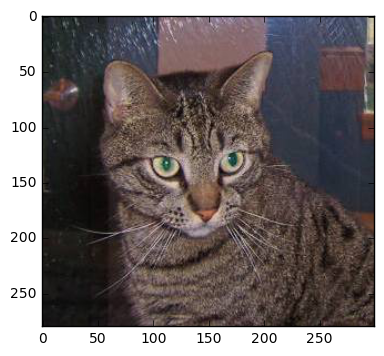

In [97]:
plt.imshow(img)

In [98]:
img = np.expand_dims(img,axis=0)

In [99]:
trial_batches = gen.flow(img)

In [100]:
imgs_aug = [next(trial_batches)[0].astype(np.uint8) for x in range(8)]

In [101]:
imgs_aug[0].shape

(280, 300, 3)

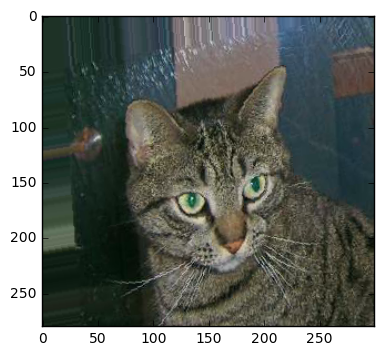

In [102]:
plt.imshow(imgs_aug[0])

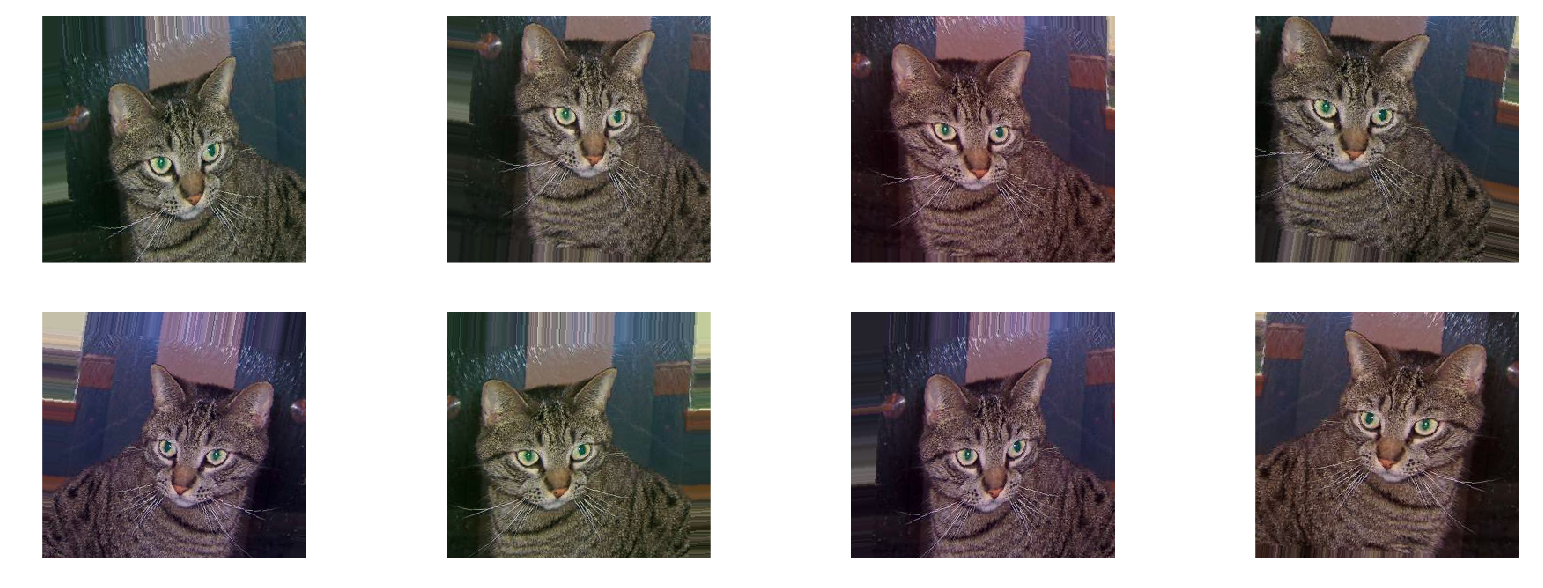

In [103]:
plots(imgs_aug, (20,7), 2)

In [126]:
K.set_image_dim_ordering('th')

In [145]:
batches = gen.flow_from_directory(path+'/train/',batch_size = batch_size)
val_batches = gen.flow_from_directory(path+'/valid/',batch_size = batch_size)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [146]:
fc_model = get_fc_model(0)

MemoryError: you might consider using 'theano.shared(..., borrow=True)'

In [120]:
fc_model.load_weights(model_path+'no_dropout.h5')

In [121]:
for layer in conv_model.layers:
    layer.trainable = False
conv_model.add(fc_model)

In [122]:
conv_model.compile(Adam(lr = 0.00001),metrics = ['accuracy'],loss = 'categorical_crossentropy')

In [131]:
batches.nb_sample

17500

In [132]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch = 5, validation_data = val_batches, 
                          nb_val_samples = val_batches.nb_sample)

Epoch 1/5


Exception: Error when checking model input: expected lambda_input_2 to have shape (None, 3, 224, 224) but got array with shape (32, 3, 256, 256)